<a href="https://colab.research.google.com/github/mixa15341/Data_Minimg/blob/main/11/%D0%BF%D1%8011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №11. Прогнозирование временных рядов, используя методы глубокого обучения**

# **Задание:**






## 1. Ознакомьтесь с библиотеками и их инструментарием
## 2. В контексте выбранного Вами набора данных, отберите несколько моделей глубокого обучения, обучите их на своих данных, после чего проведите сравнительный анализ.

## **Подготовка данных**

Загрузим датасет и подготовим данные для моделирования.

Мы будем использовать  датасет https://www.kaggle.com/datasets/bappekim/air-pollution-in-seoul?resource=download

In [ ]:
# Подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
from google.colab import drive

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
# Импортируем датасет
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_i = pd.read_csv('/content/drive/MyDrive/content/observations_mammalia_global.csv')
df_i.head()

,id,observed_on,local_time_observed_at,latitude,longitude,positional_accuracy,public_positional_accuracy,image_url,license,geoprivacy,taxon_geoprivacy,scientific_name,common_name,taxon_id
0,128984633,2022-08-02,2022-08-02 00:40:00+10:00,-30.490071,151.639271,11,11,https://static.inaturalist.org/photos/21914219...,NaN,NaN,open,Phascolarctos cinereus,Koala,42983
1,129048796,2022-08-02,2022-08-02 07:55:55+10:00,-38.671312,146.164746,24,24,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,NaN,open,Wallabia bicolor,Swamp Wallaby,42973
2,129051266,2022-08-02,2022-08-02 00:20:13+02:00,43.119623,-7.678884,8,8,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,open,Plecotus auritus,Brown Big-eared Bat,40416
3,129054418,2022-08-02,2022-08-02 00:26:13+02:00,50.686439,7.169781,6,6,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,NaN,NaN,Erinaceus europaeus,Common Hedgehog,43042
4,129076855,2022-08-02,2022-08-02 13:32:23+12:00,-40.949812,174.971092,5,5,https://inaturalist-open-data.s3.amazonaws.com...,NaN,NaN,open,Arctocephalus forsteri,New Zealand Fur Seal,41752


In [ ]:
# Создание копии и удаление лишних колонок
drop = ['taxon_geoprivacy', 'geoprivacy', 'image_url', 'license',
                   'public_positional_accuracy', 'positional_accuracy', 'taxon_id', 'local_time_observed_at', 'scientific_name']
df = df_i.drop(columns=drop)
path = '/content/drive/MyDrive/content/observations_mammalia_global_copy.csv'
df.to_csv(path, index=False)
print(df.head())

          id observed_on   latitude   longitude           common_name
0  128984633  2022-08-02 -30.490071  151.639271                 Koala
1  129048796  2022-08-02 -38.671312  146.164746         Swamp Wallaby
2  129051266  2022-08-02  43.119623   -7.678884   Brown Big-eared Bat
3  129054418  2022-08-02  50.686439    7.169781       Common Hedgehog
4  129076855  2022-08-02 -40.949812  174.971092  New Zealand Fur Seal


In [ ]:
print(df.isnull().sum())

id                0
observed_on       0
latitude          0
longitude         0
common_name    2351
dtype: int64


In [ ]:
# Удаление пропущенных значений
df = df.dropna(subset=['common_name'])

In [ ]:
print(df.isnull().sum())

id             0
observed_on    0
latitude       0
longitude      0
common_name    0
dtype: int64


In [ ]:
# Преобразование даты в числовой формат
df['observed_on'] = pd.to_datetime(df['observed_on'])
df['year'] = df['observed_on'].dt.year

In [ ]:
# Группировка данных
grouped = df.groupby(['year', 'common_name']).size().reset_index(name='count')

In [ ]:
# Преобразование в временной ряд
pivot = grouped.pivot(index='year', columns='common_name', values='count').fillna(0)

# Преобразование в numpy массив
data = pivot.values

In [ ]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [ ]:
look_back = 4  # Количество предыдущих временных шагов для использования в качестве входных данных

In [ ]:
# Преобразование данных в последовательности (X, Y)
def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        # Формирование последовательности входных данных длиной look_back
        X.append(dataset[i:i + look_back])
        # Целевое значение - следующий элемент после последовательности
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

In [ ]:
# Разбиение на обучающую и тестовую выборки
X, Y = create_dataset(data_scaled, look_back)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [ ]:
print(X_train.shape, Y_train.shape)

(15, 4, 4377) (15, 4377)


## **1. Рекуррентная нейронная сеть (RNN)**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
# Построение модели
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(look_back, X_train.shape[2]), activation='tanh'))
model_rnn.add(Dense(X_train.shape[2]))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history = model_rnn.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=15,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_rnn = model_rnn.predict(X_train)
test_predict_rnn = model_rnn.predict(X_test)


Epoch 1/100
1/1 - 2s - loss: 0.1151 - val_loss: 0.0935 - 2s/epoch - 2s/step
Epoch 2/100
1/1 - 0s - loss: 0.1173 - val_loss: 0.0901 - 74ms/epoch - 74ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1110 - val_loss: 0.0871 - 51ms/epoch - 51ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1049 - val_loss: 0.0834 - 51ms/epoch - 51ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0989 - val_loss: 0.0790 - 79ms/epoch - 79ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0928 - val_loss: 0.0747 - 65ms/epoch - 65ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0865 - val_loss: 0.0708 - 55ms/epoch - 55ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0806 - val_loss: 0.0675 - 56ms/epoch - 56ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0752 - val_loss: 0.0647 - 73ms/epoch - 73ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0703 - val_loss: 0.0623 - 58ms/epoch - 58ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0659 - val_loss: 0.0603 - 34ms/epoch - 34ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0620 - val_loss: 0.0588 - 53ms/epoch - 53ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0587 - va



1. **Вычисление метрики RMSE**:



  - **Обратите внимание**: Перед вычислением метрики мы приводим предсказанные значения и истинные значения к исходному масштабу с помощью `inverse_transform`, чтобы метрика была интерпретируема.
  - **RMSE (корень из среднеквадратичной ошибки)** оценивает среднее отклонение прогнозов от истинных значений.

In [ ]:
# Возвращение данных в исходный масштаб
train_predict_rnn = scaler.inverse_transform(train_predict_rnn)
Y_train_actual_rnn = scaler.inverse_transform(Y_train)
test_predict_rnn = scaler.inverse_transform(test_predict_rnn)
Y_test_actual_rnn = scaler.inverse_transform(Y_test)

In [ ]:
# Вычисление RMSE
from sklearn.metrics import mean_squared_error

train_score_rnn = np.sqrt(mean_squared_error(Y_train_actual_rnn, train_predict_rnn))
test_score_rnn = np.sqrt(mean_squared_error(Y_test_actual_rnn, test_predict_rnn))
print(f'RMSE на обучающем наборе: {train_score_rnn:.2f}')
print(f'RMSE на тестовом наборе: {test_score_rnn:.2f}')

RMSE на обучающем наборе: 20.54
RMSE на тестовом наборе: 102.72


2. **Построение графика потерь во время обучения**:

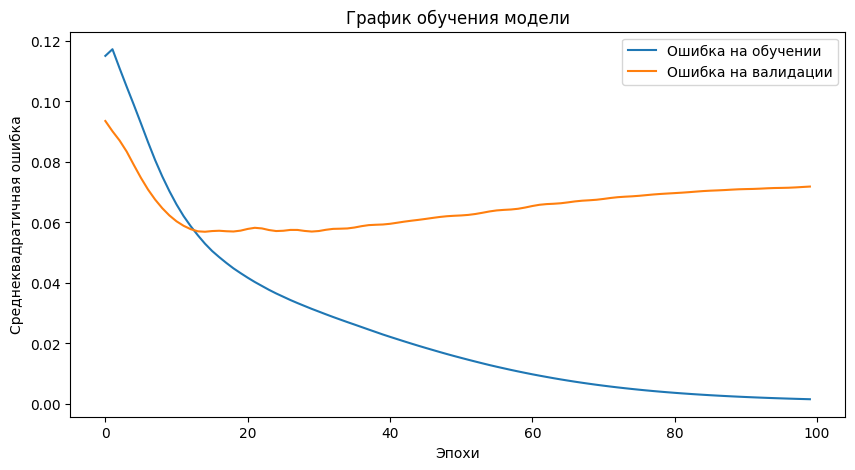

In [ ]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('График обучения модели')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

3. **Построение графика результатов моделирования**:

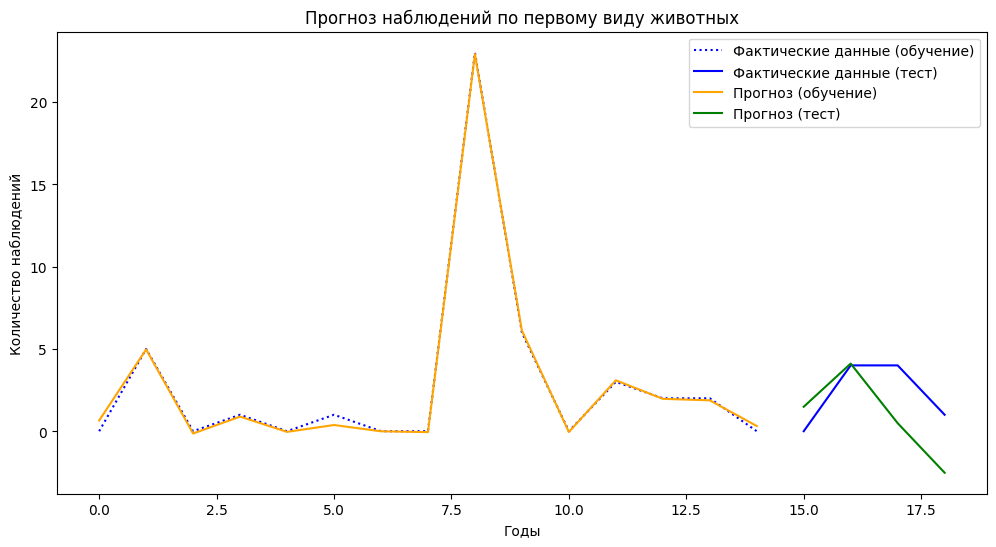

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(Y_train_actual_rnn)), Y_train_actual_rnn[:, 0], label='Фактические данные (обучение)', color='blue', linestyle='dotted')
plt.plot(np.arange(len(Y_train_actual_rnn), len(Y_train_actual_rnn) + len(Y_test_actual_rnn)), Y_test_actual_rnn[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(np.arange(len(train_predict_rnn)), train_predict_rnn[:, 0], label='Прогноз (обучение)', color='orange')
plt.plot(np.arange(len(Y_train_actual_rnn), len(Y_train_actual_rnn) + len(test_predict_rnn)), test_predict_rnn[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз наблюдений по первому виду животных')
plt.xlabel('Годы')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

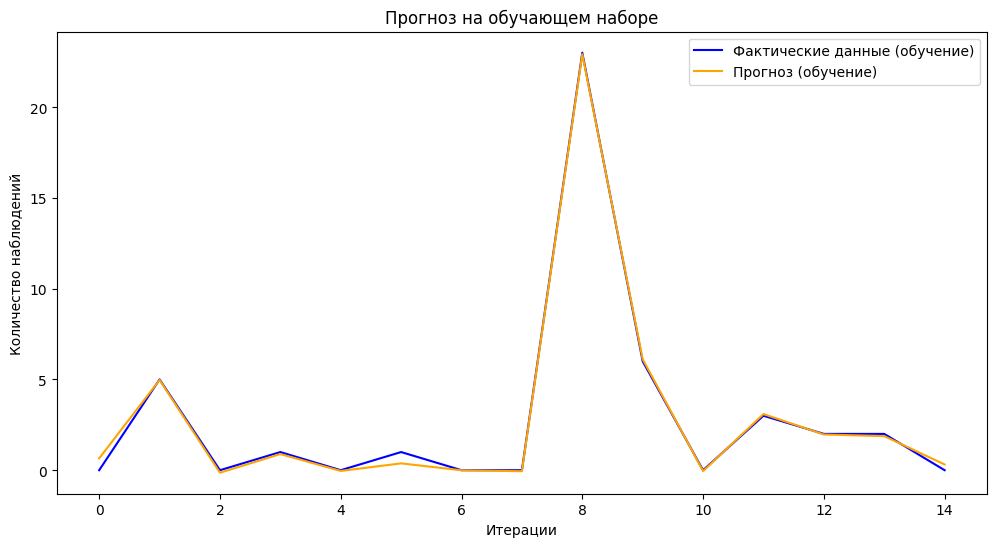

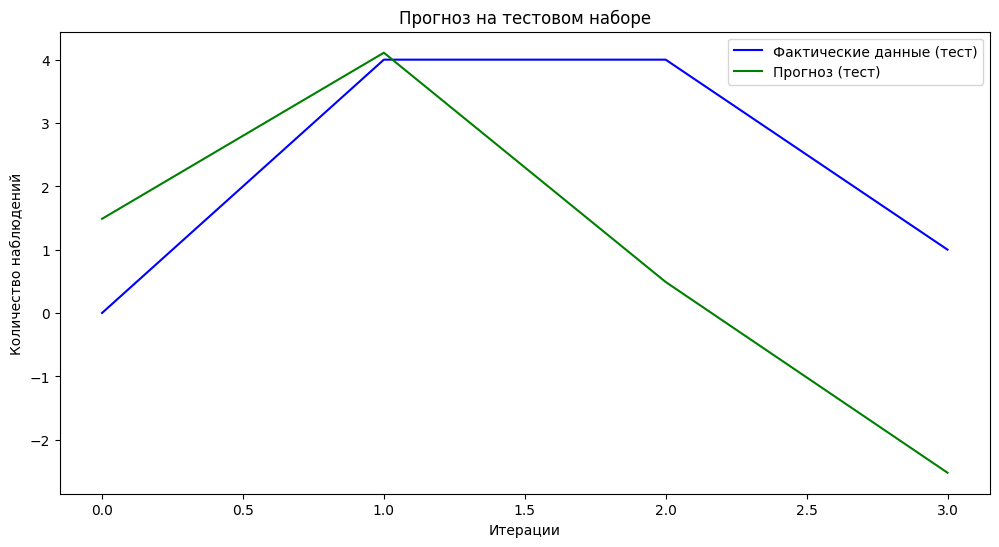

In [ ]:
# Визуализация результатов на обучающем наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_train_actual_rnn[:, 0], label='Фактические данные (обучение)', color='blue')
plt.plot(train_predict_rnn[:, 0], label='Прогноз (обучение)', color='orange')
plt.title('Прогноз на обучающем наборе')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Визуализация результатов на тестовом наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual_rnn[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(test_predict_rnn[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз на тестовом наборе')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()


## **2. Долгая краткосрочная память (LSTM)**




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Создание модели
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(25))
model_lstm.add(Dense(X_train.shape[2]))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history_lstm = model_lstm.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=15,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

Epoch 1/100
1/1 - 5s - loss: 0.1113 - val_loss: 0.0888 - 5s/epoch - 5s/step
Epoch 2/100
1/1 - 0s - loss: 0.1109 - val_loss: 0.0884 - 67ms/epoch - 67ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1103 - val_loss: 0.0878 - 74ms/epoch - 74ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1094 - val_loss: 0.0870 - 77ms/epoch - 77ms/step
Epoch 5/100
1/1 - 0s - loss: 0.1083 - val_loss: 0.0859 - 68ms/epoch - 68ms/step
Epoch 6/100
1/1 - 0s - loss: 0.1068 - val_loss: 0.0846 - 78ms/epoch - 78ms/step
Epoch 7/100
1/1 - 0s - loss: 0.1049 - val_loss: 0.0830 - 61ms/epoch - 61ms/step
Epoch 8/100
1/1 - 0s - loss: 0.1030 - val_loss: 0.0813 - 62ms/epoch - 62ms/step
Epoch 9/100
1/1 - 0s - loss: 0.1006 - val_loss: 0.0794 - 64ms/epoch - 64ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0976 - val_loss: 0.0774 - 62ms/epoch - 62ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0950 - val_loss: 0.0755 - 59ms/epoch - 59ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0927 - val_loss: 0.0737 - 63ms/epoch - 63ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0890 - va

1/1 [==============================] - 0s 33ms/step


In [ ]:
# Возвращение данных в исходный масштаб
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
Y_train_actual_lstm = scaler.inverse_transform(Y_train)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
Y_test_actual_lstm = scaler.inverse_transform(Y_test)

# Вычисление RMSE
train_score_lstm = np.sqrt(mean_squared_error(Y_train_actual_lstm, train_predict_lstm))
test_score_lstm = np.sqrt(mean_squared_error(Y_test_actual_lstm, test_predict_lstm))
print(f'RMSE на обучающем наборе: {train_score_lstm:.2f}')
print(f'RMSE на тестовом наборе: {test_score_lstm:.2f}')

RMSE на обучающем наборе: 44.71
RMSE на тестовом наборе: 23.91


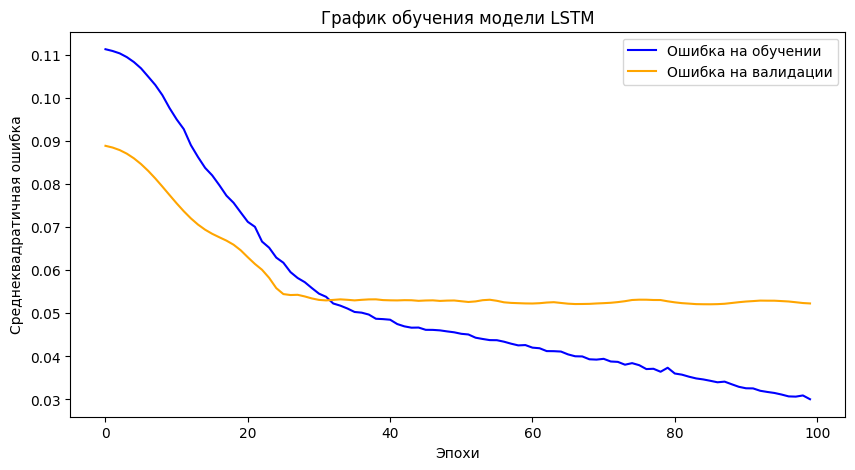

In [ ]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='Ошибка на обучении', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Ошибка на валидации', color='orange')
plt.title('График обучения модели LSTM')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

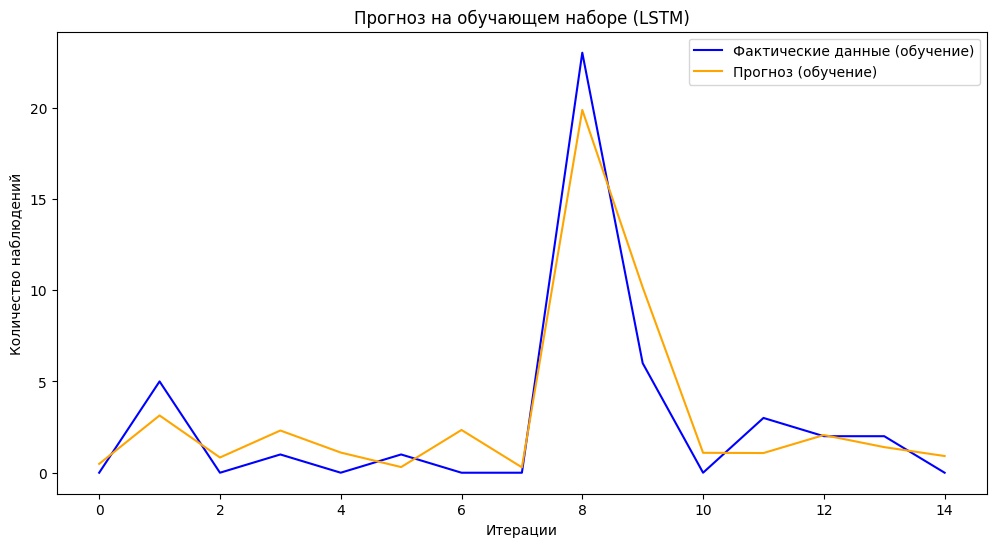

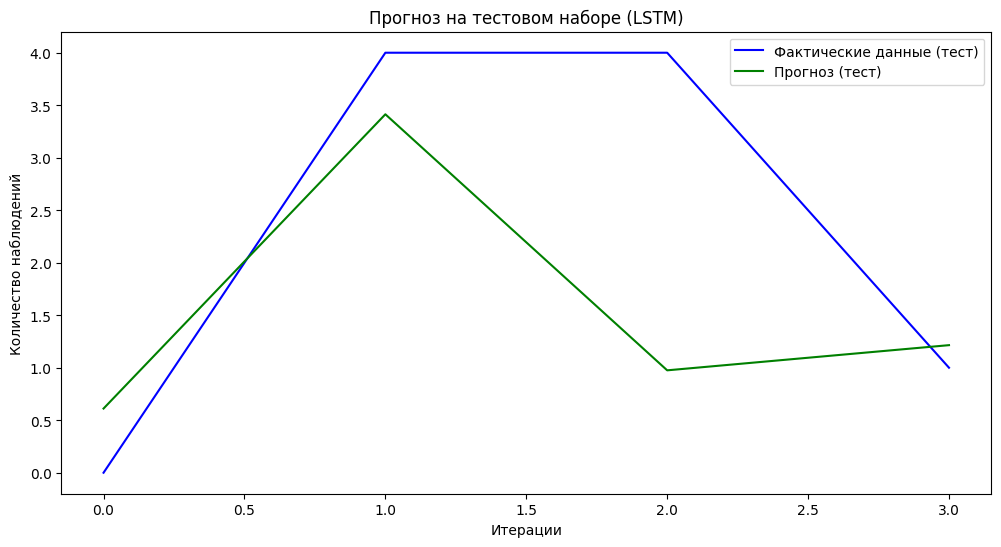

In [ ]:
# Визуализация результатов на обучающем наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_train_actual_lstm[:, 0], label='Фактические данные (обучение)', color='blue')
plt.plot(train_predict_lstm[:, 0], label='Прогноз (обучение)', color='orange')
plt.title('Прогноз на обучающем наборе (LSTM)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Визуализация результатов на тестовом наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual_lstm[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(test_predict_lstm[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз на тестовом наборе (LSTM)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

## **3. Управляемые рекуррентные блоки (GRU)**



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
# Создание модели
model_gru = Sequential()
model_gru.add(GRU(100, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(25))
model_gru.add(Dense(X_train.shape[2]))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history_gru = model_gru.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=15,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Прогнозирование
train_predict_gru = model_gru.predict(X_train)
test_predict_gru = model_gru.predict(X_test)

Epoch 1/100
1/1 - 5s - loss: 0.1113 - val_loss: 0.0889 - 5s/epoch - 5s/step
Epoch 2/100
1/1 - 0s - loss: 0.1109 - val_loss: 0.0873 - 57ms/epoch - 57ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1089 - val_loss: 0.0855 - 69ms/epoch - 69ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1063 - val_loss: 0.0834 - 53ms/epoch - 53ms/step
Epoch 5/100
1/1 - 0s - loss: 0.1034 - val_loss: 0.0811 - 56ms/epoch - 56ms/step
Epoch 6/100
1/1 - 0s - loss: 0.1004 - val_loss: 0.0786 - 56ms/epoch - 56ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0973 - val_loss: 0.0763 - 53ms/epoch - 53ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0933 - val_loss: 0.0740 - 57ms/epoch - 57ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0901 - val_loss: 0.0719 - 53ms/epoch - 53ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0862 - val_loss: 0.0700 - 52ms/epoch - 52ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0845 - val_loss: 0.0680 - 57ms/epoch - 57ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0805 - val_loss: 0.0659 - 54ms/epoch - 54ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0770 - va

1/1 [==============================] - 0s 21ms/step


In [ ]:
# Возвращение данных в исходный масштаб
train_predict_gru = scaler.inverse_transform(train_predict_gru)
Y_train_actual_gru = scaler.inverse_transform(Y_train)
test_predict_gru = scaler.inverse_transform(test_predict_gru)
Y_test_actual_gru = scaler.inverse_transform(Y_test)

# Вычисление RMSE
train_score_gru = np.sqrt(mean_squared_error(Y_train_actual_gru, train_predict_gru))
test_score_gru = np.sqrt(mean_squared_error(Y_test_actual_gru, test_predict_gru))
print(f'RMSE на обучающем наборе: {train_score_gru:.2f}')
print(f'RMSE на тестовом наборе: {test_score_gru:.2f}')

RMSE на обучающем наборе: 60.53
RMSE на тестовом наборе: 30.17


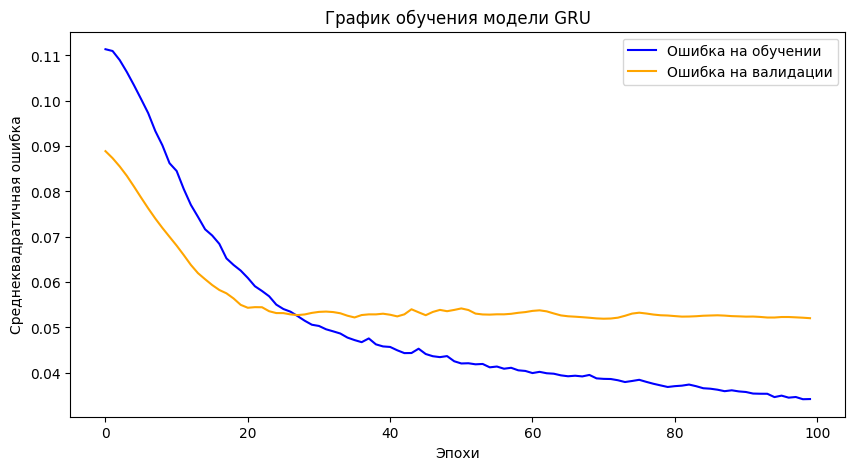

In [ ]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history_gru.history['loss'], label='Ошибка на обучении', color='blue')
plt.plot(history_gru.history['val_loss'], label='Ошибка на валидации', color='orange')
plt.title('График обучения модели GRU')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

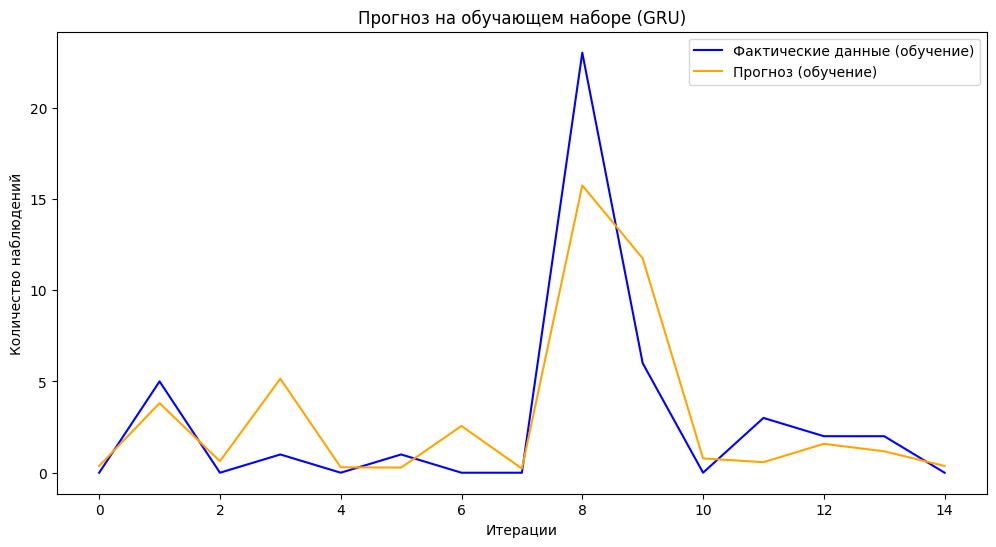

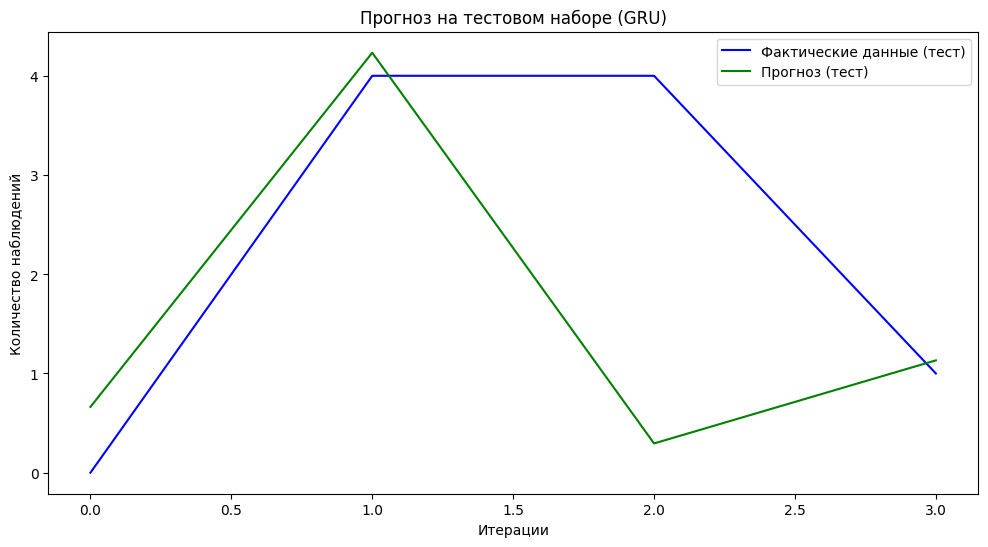

In [ ]:
# Визуализация результатов на обучающем наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_train_actual_gru[:, 0], label='Фактические данные (обучение)', color='blue')
plt.plot(train_predict_gru[:, 0], label='Прогноз (обучение)', color='orange')
plt.title('Прогноз на обучающем наборе (GRU)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

# Визуализация результатов на тестовом наборе
plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual_gru[:, 0], label='Фактические данные (тест)', color='blue')
plt.plot(test_predict_gru[:, 0], label='Прогноз (тест)', color='green')
plt.title('Прогноз на тестовом наборе (GRU)')
plt.xlabel('Итерации')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

### **4. N-BEATS**

In [ ]:
# Установка пакета nbeats-keras
!pip install nbeats-keras

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 106.5 MB/s

In [ ]:
# пришлось упростить модель и сократить данные, чтоы выполнить обучение, так как та, что была в примере лекции не загружалась

In [ ]:
from nbeats_keras.model import NBeatsNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
# Параметры модели
input_dim = X_train.shape[2]  # Количество признаков
backcast_length = look_back  # Длина истории
forecast_length = X_train.shape[2]  # Прогнозируем все признаки, а не одно значение
num_epochs = 5  # Для тестирования можно уменьшить количество эпох

# Создание упрощенной модели N-BEATS
model_nbeats = NBeatsNet(
    input_dim=input_dim,
    backcast_length=backcast_length,
    forecast_length=forecast_length,  # Прогнозируем все признаки
    stack_types=(NBeatsNet.GENERIC_BLOCK,),  # Один блок
    nb_blocks_per_stack=1,  # Уменьшаем количество блоков
    thetas_dim=(4,),  # Уменьшаем размер тета
    share_weights_in_stack=False,  # Упростим модель
    hidden_layer_units=16  # Уменьшаем количество нейронов
)

# Оптимизатор
optimizer = Adam(learning_rate=0.001)

# Компиляция модели с run_eagerly=True для отладки
model_nbeats.compile(loss='mean_squared_error', optimizer=optimizer, run_eagerly=True)

# Проверьте размерность данных
print("Размер X_train:", X_train.shape)
print("Размер Y_train:", Y_train.shape)

# Индексация на 30% данных
X_train_subset = X_train[:int(0.1 * len(X_train))]
Y_train_subset = Y_train[:int(0.1 * len(Y_train))]

# Проверьте размерность подмножества данных
print("Размер X_train_subset:", X_train_subset.shape)
print("Размер Y_train_subset:", Y_train_subset.shape)

# Обучение модели на 30% данных
history_nbeats = model_nbeats.fit(
    X_train_subset,  # Используем только 30% данных для обучения
    Y_train_subset,  # Используем только 30% целевых данных
    validation_data=(X_test, Y_test),
    epochs=num_epochs,
    batch_size=8,  # Размер батча уменьшен
    verbose=2
)

# Прогнозирование
train_predict_nbeats = model_nbeats.predict(X_train_subset)
test_predict_nbeats = model_nbeats.predict(X_test)

Размер X_train: (15, 4, 4377)
Размер Y_train: (15, 4377)
Размер X_train_subset: (1, 4, 4377)
Размер Y_train_subset: (1, 4377)
Epoch 1/5
1/1 - 73s - loss: 0.0088 - val_loss: 0.0888 - 73s/epoch - 73s/step
Epoch 2/5
1/1 - 51s - loss: 0.0087 - val_loss: 0.0884 - 51s/epoch - 51s/step
Epoch 3/5
1/1 - 49s - loss: 0.0085 - val_loss: 0.0885 - 49s/epoch - 49s/step
Epoch 4/5
1/1 - 51s - loss: 0.0081 - val_loss: 0.0892 - 51s/epoch - 51s/step
Epoch 5/5
1/1 - 48s - loss: 0.0075 - val_loss: 0.0890 - 48s/epoch - 48s/step
1/1 [==============================] - 21s 21s/step


In [ ]:
# Прогнозирование и восстановление масштаба данных
train_predict_nbeats_reshaped = train_predict_nbeats.reshape(-1, X_train.shape[2])  # Преобразование в 2D (по числу признаков)
train_predict_nbeats_inversed = scaler.inverse_transform(train_predict_nbeats_reshaped)

Y_train_actual = Y_train_subset.reshape(-1, X_train.shape[2])  # Преобразование целевого массива в нужный формат
Y_train_actual_inversed = scaler.inverse_transform(Y_train_actual)

test_predict_nbeats_reshaped = test_predict_nbeats.reshape(-1, X_train.shape[2])  # Преобразование в 2D
test_predict_nbeats_inversed = scaler.inverse_transform(test_predict_nbeats_reshaped)

Y_test_actual = Y_test.reshape(-1, X_train.shape[2])  # Преобразование целевого массива
Y_test_actual_inversed = scaler.inverse_transform(Y_test_actual)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Вычисление метрик ошибки
train_mse = mean_squared_error(Y_train_actual_inversed, train_predict_nbeats_inversed)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(Y_train_actual_inversed, train_predict_nbeats_inversed)

print('Метрики на обучающей выборке:')
print(f'MSE: {train_mse:.2f}')
print(f'RMSE: {train_rmse:.2f}')
print(f'MAE: {train_mae:.2f}')

test_mse = mean_squared_error(Y_test_actual_inversed, test_predict_nbeats_inversed)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(Y_test_actual_inversed, test_predict_nbeats_inversed)

print('\nМетрики на тестовой выборке:')
print(f'MSE: {test_mse:.2f}')
print(f'RMSE: {test_rmse:.2f}')
print(f'MAE: {test_mae:.2f}')

Метрики на обучающей выборке:
MSE: 15.08
RMSE: 3.88
MAE: 0.70

Метрики на тестовой выборке:
MSE: 47172.13
RMSE: 217.19
MAE: 14.54


Сравнение рассмотренных моделей

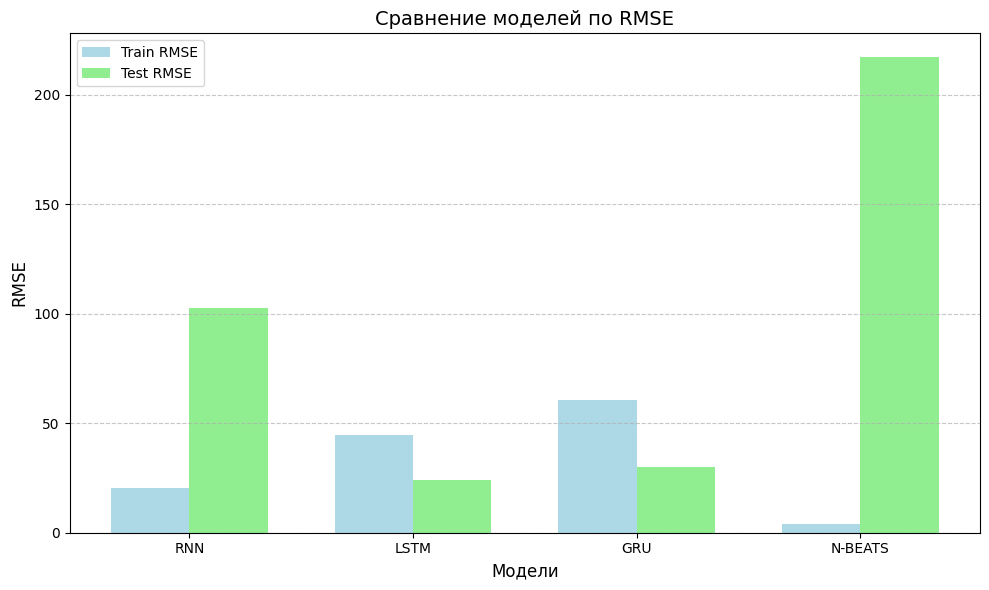

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Названия моделей
models = ['RNN', 'LSTM', 'GRU', 'N-BEATS']

# Метрики (примерные значения, замените на свои)
train_rmse = [train_score_rnn, train_score_lstm, train_score_gru, train_rmse]  # RMSE на обучении
test_rmse = [test_score_rnn, test_score_lstm, test_score_gru, test_rmse]       # RMSE на тесте

# Ширина столбцов
bar_width = 0.35

# Позиции для столбцов
x = np.arange(len(models))

# Создание фигуры
plt.figure(figsize=(10, 6))

# Построение столбчатой диаграммы
plt.bar(x - bar_width / 2, train_rmse, width=bar_width, label='Train RMSE', color='lightblue')
plt.bar(x + bar_width / 2, test_rmse, width=bar_width, label='Test RMSE', color='lightgreen')

# Настройка осей
plt.xlabel('Модели', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Сравнение моделей по RMSE', fontsize=14)
plt.xticks(x, models)  # Установка меток для оси X
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение диаграммы
plt.tight_layout()
plt.show()
